In [5]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


class BSplineActivation(nn.Module):
    def __init__(self, n_knots=10, degree=3):
        super(BSplineActivation, self).__init__()
        self.knots = torch.linspace(-1, 1, n_knots)
        self.coefficients = nn.Parameter(torch.randn(n_knots + degree - 1) * 0.01)
        self.degree = degree
        self.basis_function = nn.Parameter(torch.randn(1), requires_grad=True)

    def forward(self, x):
        return self.basis_function * F.silu(x) + self.bspline(x)

    def bspline(self, x):
        knots = self.knots.to(x.device)
        n_knots = len(knots)
        n = self.degree
        t = x

        # Initialize the dynamic programming table for the basis functions
        self.basis_functions = [[torch.zeros_like(t) for _ in range(n_knots)] for _ in range(n + 1)]

        # Define the zeroth-degree basis functions
        for i in range(n_knots - 1):
            self.basis_functions[0][i] = (t >= knots[i]) & (t < knots[i + 1])

        # Compute higher-degree basis functions using the recursive formula
        for d in range(1, n + 1):
            for i in range(n_knots - d - 1):
                if knots[i + d] != knots[i]:
                    self.basis_functions[d][i] += ((t - knots[i]) / (knots[i + d] - knots[i])) * self.basis_functions[d - 1][i]
                if knots[i + d + 1] != knots[i + 1]:
                    self.basis_functions[d][i] += ((knots[i + d + 1] - t) / (knots[i + d + 1] - knots[i + 1])) * self.basis_functions[d - 1][i + 1]

        return self.basis_functions[n][0]

class KANLayer(nn.Module):
    def __init__(self, in_features, out_features, n_knots=10, degree=3):
        super(KANLayer, self).__init__()
        self.activations = nn.ModuleList([BSplineActivation(n_knots, degree) for _ in range(in_features * out_features)])
        self.in_features = in_features
        self.out_features = out_features
        self.residual = nn.Parameter(torch.randn(out_features), requires_grad=True)

    def forward(self, x):
        output = []
        for i in range(self.out_features):
            out = self.residual[i].clone()  # Use clone to avoid in-place operation
            for j in range(self.in_features):
                out = out + self.activations[i * self.in_features + j](x[:, j])  # Use + instead of += to avoid in-place operation
            output.append(out)
        return torch.stack(output, dim=1)

class KAN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims, n_knots=10, degree=3):
        super(KAN, self).__init__()
        layers = []
        in_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(KANLayer(in_dim, hidden_dim, n_knots, degree))
            in_dim = hidden_dim
        layers.append(KANLayer(in_dim, output_dim, n_knots, degree))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)




def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += nn.CrossEntropyLoss(reduction='sum')(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)}'
          f' ({100. * correct / len(test_loader.dataset):.0f}%)\n')




In [6]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



def main():
    batch_size = 8
    test_batch_size = 8
    epochs = 20
    lr = 0.05 
    grid_size = 16
    hidden_dims = [16, 8]
    log_interval = 16
    seed = 1

    torch.manual_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    iris = load_iris()
    X = iris.data
    y = iris.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
    test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

    model = KAN(input_dim=4, output_dim=3, hidden_dims=hidden_dims, n_knots=grid_size).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr)

    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch, log_interval)
        test(model, device, test_loader)

if __name__ == '__main__':
    main()


Train Epoch: 1 [0/105 (0%)]	Loss: 2.547048

Test set: Average loss: 0.6332, Accuracy: 27/45 (60%)

Train Epoch: 2 [0/105 (0%)]	Loss: 0.651742

Test set: Average loss: 0.5606, Accuracy: 30/45 (67%)

Train Epoch: 3 [0/105 (0%)]	Loss: 0.500703

Test set: Average loss: 0.5295, Accuracy: 34/45 (76%)

Train Epoch: 4 [0/105 (0%)]	Loss: 0.302686

Test set: Average loss: 0.5087, Accuracy: 35/45 (78%)

Train Epoch: 5 [0/105 (0%)]	Loss: 0.416980

Test set: Average loss: 0.5082, Accuracy: 36/45 (80%)

Train Epoch: 6 [0/105 (0%)]	Loss: 0.416879

Test set: Average loss: 0.4738, Accuracy: 39/45 (87%)

Train Epoch: 7 [0/105 (0%)]	Loss: 0.571866

Test set: Average loss: 0.4739, Accuracy: 40/45 (89%)

Train Epoch: 8 [0/105 (0%)]	Loss: 0.491702

Test set: Average loss: 0.4505, Accuracy: 42/45 (93%)

Train Epoch: 9 [0/105 (0%)]	Loss: 0.564958

Test set: Average loss: 0.4331, Accuracy: 42/45 (93%)

Train Epoch: 10 [0/105 (0%)]	Loss: 0.471256

Test set: Average loss: 0.4237, Accuracy: 42/45 (93%)

Train Epo

In [7]:
# Unit tests for the KAN components
import unittest
class TestLayer(unittest.TestCase):
    def test_layer_output_dimensions(self):
        layer = KANLayer(in_features=3, out_features=2, n_knots=5, degree=3)
        inputs = torch.randn(1, 3)
        outputs = layer(inputs)
        self.assertEqual(outputs.shape, (1, 2))

    def test_layer_output_consistency(self):
        layer = KANLayer(in_features=4, out_features=1, n_knots=5, degree=3)
        inputs = torch.randn(1, 4)
        output1 = layer(inputs)
        output2 = layer(inputs)
        torch.testing.assert_allclose(output1, output2)

class TestKANModel(unittest.TestCase):
    def test_kan_flow(self):
        kan = KAN(input_dim=5, output_dim=2, hidden_dims=[10])
        input_vector = torch.randn(1, 5)
        output = kan(input_vector)
        self.assertEqual(output.shape, (1, 2))

    def test_kan_repeatability(self):
        kan = KAN(input_dim=5, output_dim=1, hidden_dims=[5])
        input_vector = torch.randn(1, 5)
        output1 = kan(input_vector)
        output2 = kan(input_vector)
        torch.testing.assert_allclose(output1, output2)

class TestSplineActivation(unittest.TestCase):
    def test_spline_output(self):
        spline_activation = BSplineActivation(n_knots=10, degree=3)
        inputs = torch.linspace(-1, 1, 10).unsqueeze(1)  # Test inputs from -1 to 1
        outputs = spline_activation(inputs)
        self.assertEqual(outputs.shape, inputs.shape)
        self.assertIsInstance(outputs, torch.Tensor)

# This part replaces unittest.main()
def run_tests():
    unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestLayer))
    unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestKANModel))
    unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestSplineActivation))

if __name__ == '__main__':
    run_tests()

C:\Users\maryam\AppData\Local\Temp\ipykernel_17952\911108499.py:15: FutureWarning: `torch.testing.assert_allclose()` is deprecated since 1.12 and will be removed in a future release. Please use `torch.testing.assert_close()` instead. You can find detailed upgrade instructions in https://github.com/pytorch/pytorch/issues/61844.
  torch.testing.assert_allclose(output1, output2)
..
----------------------------------------------------------------------
Ran 2 tests in 0.018s

OK
.C:\Users\maryam\AppData\Local\Temp\ipykernel_17952\911108499.py:29: FutureWarning: `torch.testing.assert_allclose()` is deprecated since 1.12 and will be removed in a future release. Please use `torch.testing.assert_close()` instead. You can find detailed upgrade instructions in https://github.com/pytorch/pytorch/issues/61844.
  torch.testing.assert_allclose(output1, output2)
.
----------------------------------------------------------------------
Ran 2 tests in 0.264s

OK
.
----------------------------------------

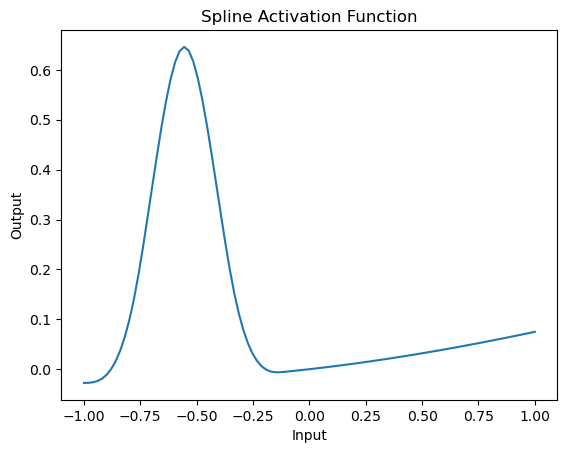

In [8]:
# Plot the spline activation function
import matplotlib.pyplot as plt
spline_activation = BSplineActivation(n_knots=10, degree=3)
x = torch.linspace(-1, 1, 100)
y = spline_activation(x).detach().numpy()

plt.plot(x.numpy(), y)
plt.xlabel("Input")
plt.ylabel("Output")
plt.title("Spline Activation Function")
plt.show()